## CNN 

In [1]:
import numpy as np 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.optimizers import Adam
from keras import regularizers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from PyFunctions import Functions as func
from PyFunctions import var
from PyFunctions import Viz
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

Using plaidml.keras.backend backend.


### CNN Model 
- The function below will compile and return a CNN model given the input dimensions 
- Categorical Crossentropy was used because the model is used to predict between three classes (0 = No Weapon, 1 = Handgun, 2 = Rifle) 
- Softmax output was used because this is a ternary classification problem 
- To ensure that training continued for more than 20 epochs
- Dimension for thie model is optimized at (150, 150, 1) 
- All visualization functions can be found in the Viz.py file within the PyFunctions folder

In [2]:
#change edge parameter to false if you are using a non edges train_test_split
edge = True
x_train, x_test, y_train, y_test = func.get_samples('normal', edge = edge)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(6062, 150, 150, 1) (674, 150, 150, 1)
(6062, 3) (674, 3)


- Running the cell below will show you what the input images look like.  
- Creating these images used a gaussian filter that outline the edges within a photo 
- Using this approach allowed the algorithm to learn distinctive shapes between weapons

In [7]:
import cv2 

cv2.imshow('test', x_train[1000])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [3]:
def get_conv_model_normal(dim):
    '''This function will create and compile a CNN given the input dimension'''
    inp_shape = dim
    act = 'relu'
    drop = .25
    kernal_reg = regularizers.l1(.001)
    optimizer = Adam(lr = .0001)
    
    model = Sequential() 
    
    model.add(Conv2D(64, kernel_size=(3,3),activation=act, input_shape = inp_shape, 
                     kernel_regularizer = kernal_reg,
                     kernel_initializer = 'he_uniform',  padding = 'same', name = 'Input_Layer'))
    model.add(MaxPooling2D(pool_size=(2, 2),  strides = (3,3)))
    
    
    model.add(Conv2D(64, (3, 3), activation=act, kernel_regularizer = kernal_reg, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (3,3)))
    

    
    model.add(Conv2D(128, (3, 3), activation=act, kernel_regularizer = kernal_reg, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(Conv2D(128, (3, 3), activation=act, kernel_regularizer = kernal_reg, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (3,3)))

    
    model.add(Flatten())

    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))

    model.add(Dropout(drop))

    model.add(Dense(3, activation='softmax', name = 'Output_Layer'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model 




# With Augmentation
- First started with augmentation of each image to determine if this would make the accuracy better

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint('ModelWeights/EdgeUnbalancedAugment.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')
epochs = 1000
batch_size = 32

if edge == True: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
    
normal_model = get_conv_model_normal(dim =dim)


augmentation =ImageDataGenerator(rotation_range = 20, width_shift_range = .2, height_shift_range = .2, 
                                                       horizontal_flip = True, shear_range = .15, 
                                 fill_mode = 'nearest', zoom_range = .15)
augmentation.fit(x_train)
normal_history = normal_model.fit_generator(augmentation.flow(x_train, y_train, batch_size = batch_size),
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)


INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


Epoch 1/1000
190/190 [==============================] - 43s 229ms/step - loss: 15.9784 - acc: 0.5391 - val_loss: 12.5271 - val_acc: 0.4377

Epoch 00001: val_loss improved from inf to 12.52713, saving model to ModelWeights/TestCNN-ModelCheckpointWeightsAugment.h5
Epoch 2/1000
190/190 [==============================] - 19s 101ms/step - loss: 12.2740 - acc: 0.4322 - val_loss: 12.1555 - val_acc: 0.3932

Epoch 00002: val_loss improved from 12.52713 to 12.15552, saving model to ModelWeights/TestCNN-ModelCheckpointWeightsAugment.h5
Epoch 3/1000
190/190 [==============================] - 19s 101ms/step - loss: 12.0550 - acc: 0.3872 - val_loss: 11.9849 - val_acc: 0.3576

Epoch 00003: val_loss improved from 12.15552 to 11.98494, saving model to ModelWeights/TestCNN-ModelCheckpointWeightsAugment.h5
Epoch 4/1000
190/190 [==============================] - 19s 101ms/step - loss: 11.9115 - acc: 0.4751 - val_loss: 11.8219 - val_acc: 0.6513

Epoch 00004: val_loss improved from 11.98494 to 11.82188, sav

190/190 [==============================] - 19s 100ms/step - loss: 4.4671 - acc: 0.6824 - val_loss: 4.2890 - val_acc: 0.6988

Epoch 00032: val_loss improved from 4.57295 to 4.28895, saving model to ModelWeights/TestCNN-ModelCheckpointWeightsAugment.h5
Epoch 33/1000
190/190 [==============================] - 19s 100ms/step - loss: 4.1843 - acc: 0.6863 - val_loss: 4.0076 - val_acc: 0.6914

Epoch 00033: val_loss improved from 4.28895 to 4.00763, saving model to ModelWeights/TestCNN-ModelCheckpointWeightsAugment.h5
Epoch 34/1000
190/190 [==============================] - 19s 100ms/step - loss: 3.9166 - acc: 0.6865 - val_loss: 3.7504 - val_acc: 0.6929

Epoch 00034: val_loss improved from 4.00763 to 3.75036, saving model to ModelWeights/TestCNN-ModelCheckpointWeightsAugment.h5
Epoch 35/1000
190/190 [==============================] - 19s 100ms/step - loss: 3.6503 - acc: 0.6876 - val_loss: 3.5345 - val_acc: 0.6795

Epoch 00035: val_loss improved from 3.75036 to 3.53453, saving model to ModelWei

190/190 [==============================] - 19s 100ms/step - loss: 0.7642 - acc: 0.7577 - val_loss: 0.7403 - val_acc: 0.7596

Epoch 00097: val_loss improved from 0.74079 to 0.74027, saving model to ModelWeights/TestCNN-ModelCheckpointWeightsAugment.h5
Epoch 98/1000
190/190 [==============================] - 19s 100ms/step - loss: 0.7541 - acc: 0.7553 - val_loss: 0.7406 - val_acc: 0.7641

Epoch 00098: val_loss did not improve from 0.74027
Epoch 99/1000
190/190 [==============================] - 19s 101ms/step - loss: 0.7584 - acc: 0.7545 - val_loss: 0.7376 - val_acc: 0.7715

Epoch 00099: val_loss improved from 0.74027 to 0.73764, saving model to ModelWeights/TestCNN-ModelCheckpointWeightsAugment.h5
Epoch 100/1000
190/190 [==============================] - 19s 101ms/step - loss: 0.7474 - acc: 0.7629 - val_loss: 0.7393 - val_acc: 0.7671

Epoch 00100: val_loss did not improve from 0.73764
Epoch 101/1000
190/190 [==============================] - 19s 101ms/step - loss: 0.7479 - acc: 0.7608 -

In [10]:
# print(normal_model.summary())

### Loss & Accuracy With Augment

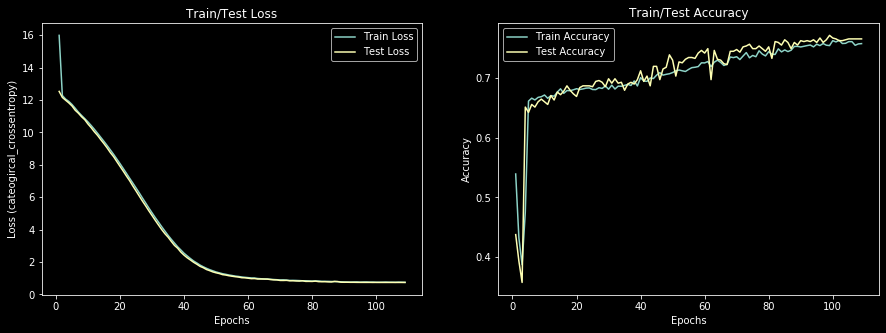

In [11]:
Viz.plot_loss_accuracy(normal_history, 'dark_background')  

### AUC and ROC Curves With Augment

F1 Scores Test
~~~~~~~~~~~~~~~~~~~~~~
No Weapon: 0.8668076109936576
HandGun: 0.776255707762557
Rifle: 0.5504587155963302


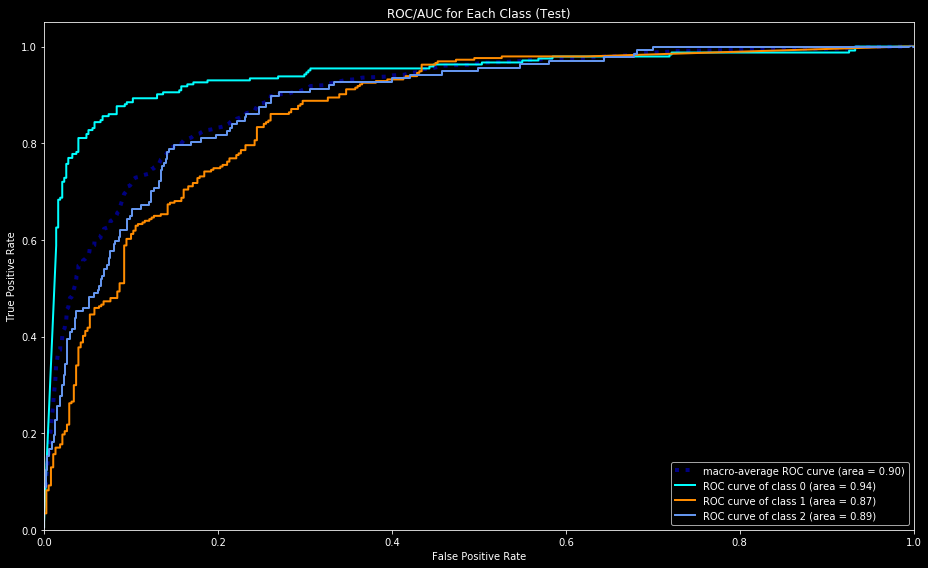

In [12]:
if edge == True: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
    
normal_model = get_conv_model_normal(dim)
normal_model.load_weights('ModelWeights/EdgeUnbalancedAugment.h5') #load the best weights before overfitting
 


Viz.plot_roc_auc(normal_model, x_test, y_test, 'dark_background')

### Confusion Matrix With Augment

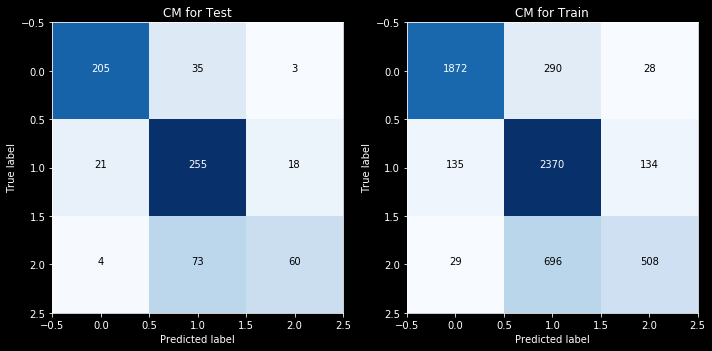

In [13]:
if edge == True: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
        
normal_model = get_conv_model_normal(dim)
normal_model.load_weights('ModelWeights/EdgeUnbalancedAugment.h5') #load the best weights before overfitting





y_test_prob = [np.argmax(i) for i in normal_model.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in normal_model.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Weapon', 'Handgun', 'Rifle'], theme = 'dark_background', 
                  )


# No Augmention

In [4]:
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint('ModelWeights/EdgeUnbalancedNoAugment.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')
epochs = 1000
batch_size = 32

if edge == True: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
    
normal_model = get_conv_model_normal(dim =dim)


normal_history = normal_model.fit(x_train, y_train, batch_size = batch_size,
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)


INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


Train on 6062 samples, validate on 674 samples
Epoch 1/1000


INFO:plaidml:Analyzing Ops: 90 of 422 operations complete


6062/6062 [==============================] - 43s 7ms/step - loss: 18.3960 - acc: 0.5031 - val_loss: 12.2396 - val_acc: 0.6365

Epoch 00001: val_loss improved from inf to 12.23963, saving model to ModelWeights/TestCNN-ModelCheckpointWeightsNoAugment.h5
Epoch 2/1000
6062/6062 [==============================] - 18s 3ms/step - loss: 12.1323 - acc: 0.5878 - val_loss: 12.0158 - val_acc: 0.6706

Epoch 00002: val_loss improved from 12.23963 to 12.01584, saving model to ModelWeights/TestCNN-ModelCheckpointWeightsNoAugment.h5
Epoch 3/1000
6062/6062 [==============================] - 19s 3ms/step - loss: 11.9063 - acc: 0.6041 - val_loss: 11.8599 - val_acc: 0.6736

Epoch 00003: val_loss improved from 12.01584 to 11.85991, saving model to ModelWeights/TestCNN-ModelCheckpointWeightsNoAugment.h5
Epoch 4/1000
6062/6062 [==============================] - 18s 3ms/step - loss: 11.7479 - acc: 0.6034 - val_loss: 11.7495 - val_acc: 0.6691

Epoch 00004: val_loss improved from 11.85991 to 11.74953, saving mod

6062/6062 [==============================] - 18s 3ms/step - loss: 5.8840 - acc: 0.8570 - val_loss: 6.3040 - val_acc: 0.7092

Epoch 00032: val_loss improved from 6.50689 to 6.30404, saving model to ModelWeights/TestCNN-ModelCheckpointWeightsNoAugment.h5
Epoch 33/1000
6062/6062 [==============================] - 18s 3ms/step - loss: 5.6759 - acc: 0.8642 - val_loss: 6.2570 - val_acc: 0.7136

Epoch 00033: val_loss improved from 6.30404 to 6.25696, saving model to ModelWeights/TestCNN-ModelCheckpointWeightsNoAugment.h5
Epoch 34/1000
6062/6062 [==============================] - 18s 3ms/step - loss: 5.4758 - acc: 0.8832 - val_loss: 6.0068 - val_acc: 0.7151

Epoch 00034: val_loss improved from 6.25696 to 6.00676, saving model to ModelWeights/TestCNN-ModelCheckpointWeightsNoAugment.h5
Epoch 35/1000
6062/6062 [==============================] - 18s 3ms/step - loss: 5.2644 - acc: 0.8941 - val_loss: 5.9460 - val_acc: 0.7285

Epoch 00035: val_loss improved from 6.00676 to 5.94604, saving model to Mo


Epoch 00064: val_loss improved from 3.54544 to 3.54037, saving model to ModelWeights/TestCNN-ModelCheckpointWeightsNoAugment.h5
Epoch 65/1000
6062/6062 [==============================] - 18s 3ms/step - loss: 2.1154 - acc: 0.9903 - val_loss: 3.5770 - val_acc: 0.7359

Epoch 00065: val_loss did not improve from 3.54037
Epoch 66/1000
6062/6062 [==============================] - 18s 3ms/step - loss: 2.1007 - acc: 0.9896 - val_loss: 3.6116 - val_acc: 0.7374

Epoch 00066: val_loss did not improve from 3.54037
Epoch 67/1000
6062/6062 [==============================] - 18s 3ms/step - loss: 2.0904 - acc: 0.9913 - val_loss: 3.6035 - val_acc: 0.7315

Epoch 00067: val_loss did not improve from 3.54037
Epoch 68/1000
6062/6062 [==============================] - 18s 3ms/step - loss: 2.0927 - acc: 0.9904 - val_loss: 3.6015 - val_acc: 0.7344

Epoch 00068: val_loss did not improve from 3.54037
Epoch 69/1000
6062/6062 [==============================] - 19s 3ms/step - loss: 2.0892 - acc: 0.9906 - val_loss

### Loss and Accuracy without Augment

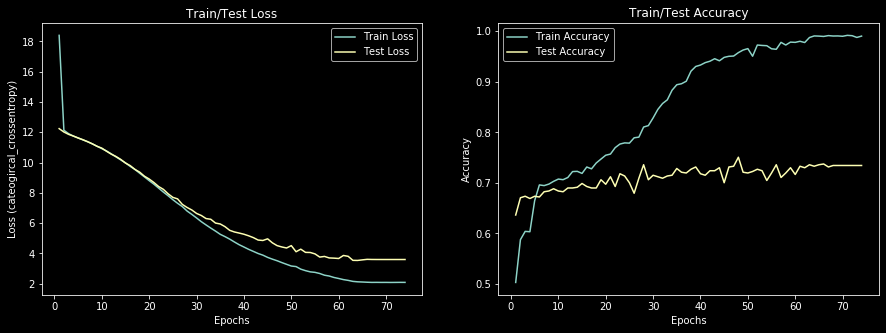

In [5]:
Viz.plot_loss_accuracy(normal_history, 'dark_background', path = 'figures/LossAccEdgeUnbalancedNoAugment.png')  

### ROC and AUC without Augment

F1 Scores Test
~~~~~~~~~~~~~~~~~~~~~~
No Weapon: 0.8232848232848233
HandGun: 0.7323481116584565
Rifle: 0.565891472868217


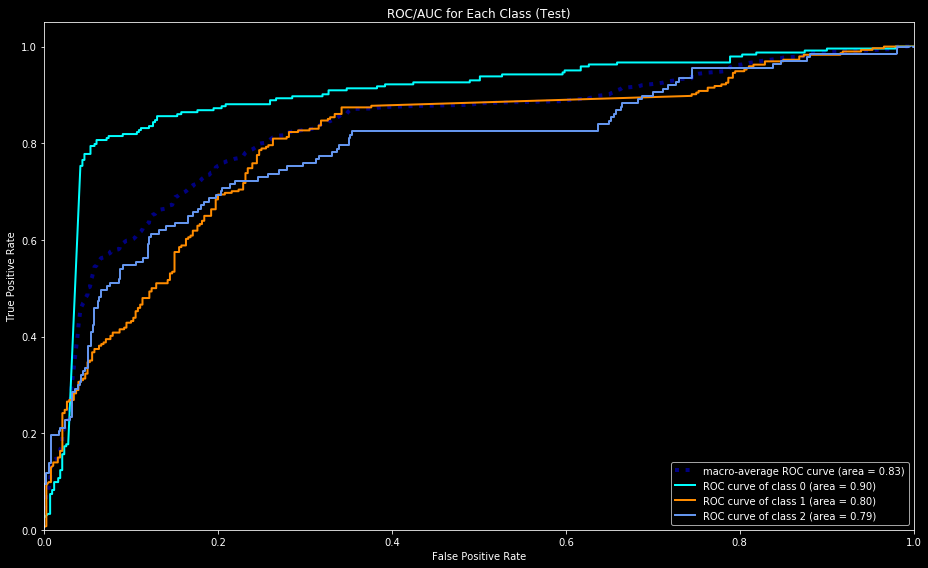

In [6]:
if edge == True: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
    
normal_model = get_conv_model_normal(dim)
normal_model.load_weights('ModelWeights/EdgeUnbalancedNoAugment.h5') #load the best weights before overfitting
 


Viz.plot_roc_auc(normal_model, x_test, y_test, 'dark_background', 'figures/ROCAUCEdgeUnbalancedNoAugment.png')

### Confusion Matrix Without Augment

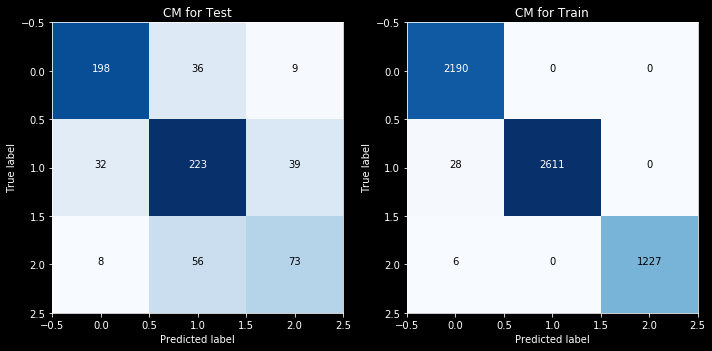

In [7]:
if edge == True: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 1)
else: 
    dim = (var.norm_dimension[0], var.norm_dimension[1], 3)
        
normal_model = get_conv_model_normal(dim)
normal_model.load_weights('ModelWeights/EdgeUnbalancedNoAugment.h5') #load the best weights before overfitting





y_test_prob = [np.argmax(i) for i in normal_model.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in normal_model.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Weapon', 'Handgun', 'Rifle'], theme = 'dark_background', 
                  path = 'figures/CMEdgeUnbalancedNoAugment.png')


## Results

- Comparing the confusion matrix of the augmented model with the non-augmented model, we can see that the non-augmented model performs much better at detection the presence of the weapon.  
- This difference can be due to the fact that the images that are being fed into the algorithm are already processes in a way that only makes it more confusing when applying augmentation as well
- The model weights `CNN-ModelCheckpointWeightsNoAugment.h5` correspond to the final model used throughout the visualizations found in `OpenCVTesting` notebook